### Подход 1: градиентный бустинг "в лоб"

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from datetime import datetime
import pandas as p
from numpy import average
import sklearn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

In [5]:
features = p.read_csv('./features.csv', index_col='match_id')
features_test = p.read_csv('./features_test.csv', index_col='match_id')
features_train = features.drop(columns=[
     "duration", 
     "radiant_win",
     "tower_status_radiant",
     "tower_status_dire",
     "barracks_status_dire",
     "barracks_status_radiant"
])

In [6]:
values_count = features_train.count().sort_values(ascending=True)

#### Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?

In [7]:
rows = values_count.max()

print("Количество пропусков\n")
for (feature, val) in sorted(values_count.iteritems()):
    values_missing = rows - val
    if values_missing > 0:
        print(f"{feature}: {values_missing}")

Количество пропусков

dire_bottle_time: 16143
dire_courier_time: 676
dire_first_ward_time: 1826
dire_flying_courier_time: 26098
first_blood_player1: 19553
first_blood_player2: 43987
first_blood_team: 19553
first_blood_time: 19553
radiant_bottle_time: 15691
radiant_courier_time: 692
radiant_first_ward_time: 1836
radiant_flying_courier_time: 27479


Много значений пропущено в колонках, касающихся First Blood (first_blood_player1, first_blood_player2, first_blood_time, first_blood_team). Это значит, что игроки никого не убили за первые 5 минут матча.

Пропуски в *_bottle_time, *_courier_time и *_flying_courier_time означают, что соответствующая команда не купила эти предметы за первые 5 минут.

Пропуски в *_first_ward_time означают, что команда не поставила ни одного наблюдателя за 5 минут.

In [8]:
features_train = features_train.fillna(value=0)

#### 2. Как называется столбец, содержащий целевую переменную?

In [9]:
Y_col = "radiant_win"


X = features_train
y = features[Y_col]

#### 3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.

In [10]:
kfold = KFold(shuffle=True, n_splits=5)

Обучается классификатор с 10 деревьями
Среднее значения качества: 0.6646291455551827 (за 0:01:12.878092мс)

Обучается классификатор с 20 деревьями
Среднее значения качества: 0.6809860273308972 (за 0:02:18.501172мс)

**Обучается классификатор с 30 деревьями
Среднее значения качества: 0.6900458742897161 (за 0:03:09.979634мс)**

Обучается классификатор с 40 деревьями
Среднее значения качества: 0.694294321131233 (за 0:04:12.675311мс)

Обучается классификатор с 50 деревьями
Среднее значения качества: 0.6977442051399642 (за 0:05:26.558180мс)

Обучается классификатор с 60 деревьями
Среднее значения качества: 0.7002027254594443 (за 0:06:49.034804мс)

Обучается классификатор с 70 деревьями
Среднее значения качества: 0.7019988271689213 (за 0:07:50.472654мс)

Обучается классификатор с 80 деревьями
Среднее значения качества: 0.7047217159467425 (за 0:09:17.449093мс)

Обучается классификатор с 90 деревьями
Среднее значения качества: 0.7058723237655931 (за 0:09:42.171533мс)

Обучается классификатор с 100 деревьями
Среднее значения качества: 0.7069479623025787 (за 0:11:31.993495мс)

#### 4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

При количества деревьев больше 30 качество продолжает расти, не медленее. При 80+ рост замедляется ещё сильнее. К тому же, время на обучение начинает заметно увеличиваться.
Это значит, что оптимально испольховать 60 деревьев.

Чтобы ускорить обучение, можно использовать метод главных компонент.

### Подход 2: логистическая регрессия

Отмасштабируем признаки

In [11]:
from sklearn.preprocessing import StandardScaler 
import numpy as np

scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X.astype(np.float64))
X_scaled = p.DataFrame(data=X_scaled_array, index=X.index, columns=X.columns)

**1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?**

In [61]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA 

def _fit_and_score_(X, y, c):
    ll_clf = LogisticRegressionCV(cv=kfold, penalty='l2')
    ll_clf.scoring = "roc_auc"
    ll_clf.C = c
    ll_clf.fit(X, y)
    return ll_clf, ll_clf.score(X, y)

def _plot_(c, x, clf, n_features=2, feature_selector='pca'):
    if feature_selector == 'pca':
        ### PCA
        pca = PCA(n_components=n_features)
        axis = p.DataFrame(pca.fit_transform(x, y))
        y_label = x_label = None
    elif feature_selector == 'coef':
        ### Coefs (feature importance)
        features = p.DataFrame(zip(clf.coef_[0], x), columns = ["coef", "column"])
        important_features = features.nlargest(n_features, "coef")
        (y_label, x_label) = important_features['column']
        axis = x[important_features['column']]
    else:
        raise ValueError("Unknown feature selector")
    
    radiant = axis.loc[y.loc[y==1].index]
    dire = axis.loc[y.loc[y==0].index]
    fig = plt.figure()
    fig.suptitle(f"C={c}")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.scatter(radiant.iloc[:, 0], radiant.iloc[:, 1], label="Radiant", c="green")
    plt.scatter(dire.iloc[:, 0], dire.iloc[:, 1], label="Dire", c="Red")
    plt.legend()
    plt.show()
    
def fit_log_reg(X):
    best_score = None
    best_c = None
    best_clf = None
    for c in[0.001]: # [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        start_time = datetime.now()
        print(f"Обучается LogisticRegressionCV с C={c}")
        ll_clf, avg_score = _fit_and_score_(X, y, c)
        if best_score is None or avg_score > best_score:
            best_score = avg_score
            best_c = c
            best_clf = ll_clf
        exec_time = datetime.now() - start_time    
        print(f"Средний AUC-ROC = {avg_score} найден за {exec_time}мс")
    _plot_(c, X, best_clf)
    return best_clf, best_score, best_c

Обучается LogisticRegressionCV с C=0.001


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1926: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


Средний AUC-ROC = 0.7179727247149582 найден за 0:00:14.504098мс


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


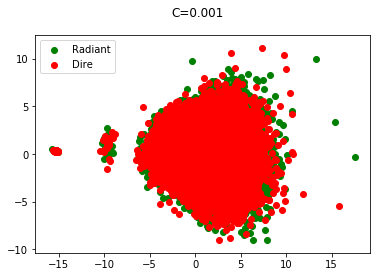


🏆 Лучшее качество логистической регрессии = 0.7179727247149582 (при c=0.001)


In [62]:
best_clf, score, c = fit_log_reg(X_scaled)
print(f"\n🏆 Лучшее качество логистической регрессии = {score} (при c={c})")

🏆 Лучшее качество логистической регрессии = 0.7179729170730196 (при c=0.001)

Качество регрессии получилось примерно таким же, как при бустинге (~0.7). Я думаю, это обусловлено тем, что я никак не изменил датасет (не считая масштабирования). Но регрессия работает примерно в 20 раз быстрее бустинга — около 20 секунд против 7 минут.

**2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?**

Уберем категориальные признаки из выборки

In [ ]:
from itertools import chain

categorial_features = list(chain.from_iterable((f"r{i}_hero", f"d{i}_hero") for i in range(1, 6))) # heroes
categorial_features += ["lobby_type"]

In [ ]:
X_with_no_categorial_features = X_scaled.filter([x for x in X_scaled.columns if x not in categorial_features])

Обучим регрессию на выборке без категориальных признаков

🏆 Лучшее качество на выборке без категориальных признаков: 0.7178321808820098 (c=0.001)

Качество получилось чуть хуже, чем на выборке с категориальными признаками (0.7178). Возможно, оно не изменилось потому, что эти признаки не влияли на результат.